<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/NewsvendorActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 5000: Avg Reward -24.61, Avg Order 105.62
Episode 10000: Avg Reward -25.00, Avg Order 102.27
Episode 15000: Avg Reward -25.51, Avg Order 114.77
Episode 20000: Avg Reward -22.55, Avg Order 108.05
Episode 25000: Avg Reward -23.66, Avg Order 108.53
Episode 30000: Avg Reward -23.10, Avg Order 109.00
Episode 35000: Avg Reward -23.26, Avg Order 109.61
Episode 40000: Avg Reward -23.25, Avg Order 108.88
Episode 45000: Avg Reward -22.94, Avg Order 111.70
Episode 50000: Avg Reward -22.30, Avg Order 110.13
Episode 55000: Avg Reward -23.59, Avg Order 103.53
Episode 60000: Avg Reward -25.38, Avg Order 115.71
Episode 65000: Avg Reward -23.45, Avg Order 115.05
Episode 70000: Avg Reward -22.50, Avg Order 110.21
Episode 75000: Avg Reward -22.45, Avg Order 113.29
Episode 80000: Avg Reward -23.35, Avg Order 103.23
Episode 85000: Avg Reward -22.13, Avg Order 105.84
Episode 90000: Avg Reward -22.55, Avg Order 104.90
Episode 95000: Avg Reward -23.28, Avg Order 102.91
Episode 100000: Avg Reward -23.3

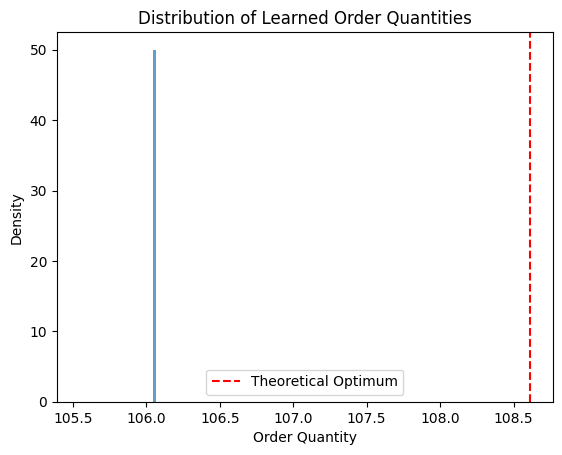

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import norm

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Environment for the one-period inventory (newsvendor) problem
class InventoryEnv:
    def __init__(self, mu=100, sigma=20, shortage_cost=2.0, overage_cost=1.0):
        self.mu = mu
        self.sigma = sigma
        self.cs = shortage_cost
        self.co = overage_cost

    def reset(self):
        # The state is the last demand (or a baseline demand)
        self.last_demand = self.mu
        return np.array([self.last_demand], dtype=np.float32)

    def step(self, action):
        # Draw demand from N(mu, sigma) and clip at 0.
        demand = max(np.random.normal(self.mu, self.sigma), 0)
        # Compute overage (if order > demand) and shortage (if demand > order)
        overage = max(action - demand, 0)
        shortage = max(demand - action, 0)
        cost = self.co * overage + self.cs * shortage
        reward = -cost  # reward is negative cost
        next_state = np.array([demand], dtype=np.float32)
        done = True  # one-step episode
        return next_state, reward, done, {}

# Residual Actor network: outputs an adjustment to the baseline order (state).
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_dim=16):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_delta = nn.Linear(hidden_dim, 1)
        # A single learned log_std parameter (initialized to 0 => std = 1)
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        delta = self.fc_delta(x)  # adjustment (initialized near 0)
        order = state + delta   # residual connection: baseline + adjustment
        order = torch.clamp(order, min=0)  # ensure non-negative order
        std = torch.exp(self.log_std).expand_as(order)
        return order, std

# Critic network: estimates the state value.
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=16):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_value = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc_value(x)
        return value

# Parameters for the inventory problem
mu_d = 100
sigma_d = 20
shortage_cost = 2
overage_cost = 1

env = InventoryEnv(mu=mu_d, sigma=sigma_d, shortage_cost=shortage_cost, overage_cost=overage_cost)
state_dim = 1

# Create actor and critic networks
actor = Actor(state_dim)
critic = Critic(state_dim)

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# Training settings: one-step episodes
num_episodes = 20000

episode_rewards = []
order_quantities = []

for episode in range(num_episodes):
    state = env.reset()  # state is [100]
    state_tensor = torch.FloatTensor(state).unsqueeze(0)

    # Actor outputs a mean order and std.
    mu_policy, std_policy = actor(state_tensor)
    dist_policy = dist.Normal(mu_policy, std_policy)
    action = dist_policy.sample()
    # Ensure non-negative action.
    action_clipped = torch.clamp(action, min=0)

    # Step the environment.
    next_state, reward, done, _ = env.step(action_clipped.item())
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
    # Here we use the immediate reward directly (no bootstrapping for one-step).
    reward_tensor = torch.tensor(reward, dtype=torch.float32)

    # Critic evaluates the current state.
    value = critic(state_tensor)
    target = reward_tensor  # one-step episode target
    advantage = target - value

    # Actor loss: maximize log(probability) * advantage.
    actor_loss = -dist_policy.log_prob(action) * advantage.detach()
    # Optional entropy bonus for exploration.
    actor_loss -= 0.001 * dist_policy.entropy()

    # Critic loss: squared TD error.
    critic_loss = advantage.pow(2)

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    episode_rewards.append(reward)
    order_quantities.append(action_clipped.item())

    if (episode+1) % 5000 == 0:
        avg_reward = np.mean(episode_rewards[-5000:])
        avg_order = np.mean(order_quantities[-5000:])
        print(f"Episode {episode+1}: Avg Reward {avg_reward:.2f}, Avg Order {avg_order:.2f}")

# Evaluation: run many episodes using the deterministic (mean) policy.
eval_orders = []
num_eval = 1000
for _ in range(num_eval):
    state = env.reset()
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    mu_policy, std_policy = actor(state_tensor)
    dist_policy = dist.Normal(mu_policy, std_policy)
    # Sample from the policy instead of taking the mean
    # order = dist_policy.sample().item()
    order = mu_policy.item()  # use the mean action

    eval_orders.append(order)


avg_learned_order = np.mean(eval_orders)
print("\nLearned average order quantity: {:.2f}".format(avg_learned_order))

# Theoretical optimum using the newsvendor critical fractile.
opt_quantile = shortage_cost / (shortage_cost + overage_cost)
optimal_order = mu_d + sigma_d * norm.ppf(opt_quantile)
print("Theoretical optimum order quantity: {:.2f}".format(optimal_order))

# Plot the distribution of learned orders.
plt.hist(eval_orders, bins=50, density=True, alpha=0.7)
plt.axvline(optimal_order, color='red', linestyle='--', label='Theoretical Optimum')
plt.xlabel('Order Quantity')
plt.ylabel('Density')
plt.title('Distribution of Learned Order Quantities')
plt.legend()
plt.show()
